<H2>librarys installieren</H2>

In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio

2026-01-15 21:17:17.385177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-15 21:17:17.402720: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-15 21:17:17.408062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-15 21:17:17.421927: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-15 21:17:18.220572: W tensorflow/compiler/tf2

In [2]:
DATA_PATH = "data_gtzan_mfcc.json"

<H1>Genre Klassifikation von Musik</H1>

Unternehmen wie Spotify oder Shazam habe es geschafft Musikdateien clever zu nutzen und so einen echten Merhwert für Nutzer anzubieten. Im Zuge dieses Projekts wollte ich mich mit der Aufbereitung von rohen Musikdateien befassen und ein Modell entwicklen, welches Songs automatisch nach ihrem Genre klassifiziert. Ein neuronales Netzwerk könnte die Effizienz von Musikdatenbanken wie Spotify erheblich steigern. Es könnte bei Musikempfehlungen und Playlist-Generatoren helfen. Auf Basis bestehender Literatur werden für dieses Projekt zwei Convolutional Neural Networks (CNN) getestet. 

Als Datengrundlage für dieses Projekt wird der GTZAN Genre Collection Dataset verwendet. Der Datensatz besteht aus insgesamt 1’000 Musikstücken, die auf 10 verschiedene Musikgenres verteilt sind (je 100 Titel pro Genre). Jeder Track hat eine Länge von 30 Sekunden und liegt im WAV-Format vor.

Inhalte in diesem Notebook: 
<ol>
  <li>von der rohen Musikdatei zur Merkmalextraktion für maschinelles lernen</li>
  <li>CNN Modell für die Genre Klassifikation</li>
  <li>erweitertes CNN Modell für die Genre Klassifikation</li>
    <li>Interpretation und Ergebnisse</li>
</ol>

<H1>1. von der rohen Musikdatei zur Merkmalextraktion für maschinelles lernen</H1>

Ein Musikbeispiel aus dem GTZAN Datenset.

In [3]:
audio = "Musikbeispiel/hiphop.00099.wav"
Audio(audio)

Was unser Gehör unweigerlich als Hip Hop interpretieren kann ist für ein Computer nicht so trivial. Um die Datei für maschinelles Lernen verwenden zu können müssen wir die rohe Musikdatei in ein brauchbares Format umwandeln. Die Library <code>librosa</code> hilft uns dabei.

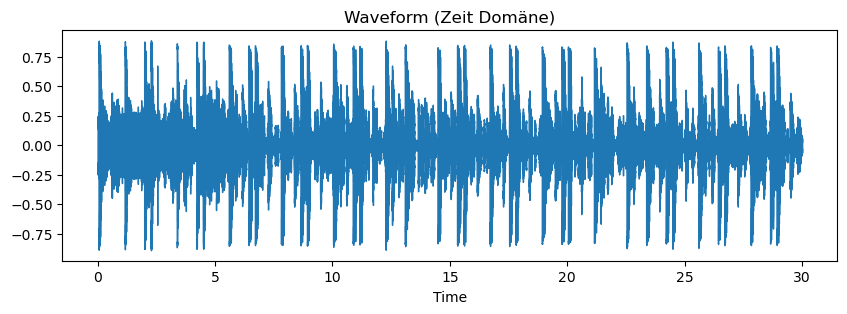

In [4]:
y, sr = librosa.load(audio, sr=22050)

plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform (Zeit Domäne)")
plt.show()

Die Waveform Darstellung zeigt die Amplitudenwerte der Audiodatei über die Zeit. Höhere Ausschläge entsprechen einer höheren Lautstärke. Diese Amplitudenwerte sind nicht besonders aussagekräftig, da sie nur über die Lautstärke der Musikdatei etwas aussagen. Um die Musikdatei besser verstehen zu können ist es notwendig sie in eine Frequency-Domain zu transformieren.

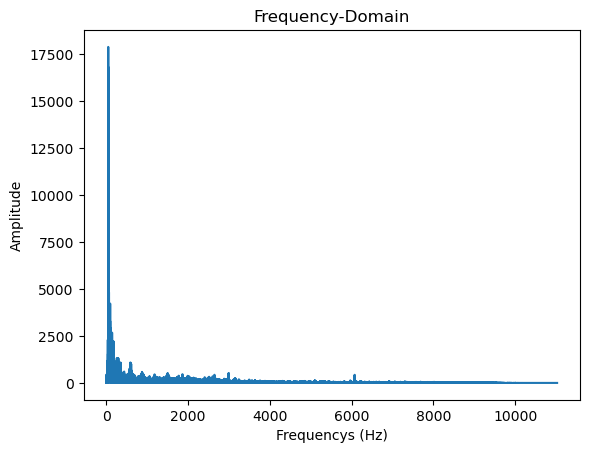

In [5]:
fft = np.fft.fft(y)
magnitude = np.abs(fft)
frequency = np.fft.fftfreq(len(magnitude), 1/sr)

idx = frequency>= 0

plt.plot(frequency[idx], magnitude[idx])
plt.title("Frequency-Domain")
plt.xlabel("Frequencys (Hz)")
plt.ylabel("Amplitude")
plt.show()

Der Plot zeigt, welche Frequenzanteile in der Audiodatei vorhanden sind, jedoch verlieren wir wieder die zeitliche Auflösung. 

Da die Musikdatei zeitlich variierende Frequenzanteile enthält, wird im nächsten Schritt eine zeitaufgelöste Darstellung betrachtet. Unser Hörvermögen nimmt Frequenzen nicht linear wahr. Tiefe Frequenzen können sehr fein unterschieden werden, bei höheren Frequenzen bekunden wir mühe Unterschiede festzustellen. Um dies zu berücksichtigen wird die Frequenzachse auf die sogennante Mel-Skala abgebildet. Diese Skala ist so definiert, dass gleiche Abstände auf der Mel-Skala in etwa gleichen wahrgenommenen Tonhöhenunterschiede entsprechen.

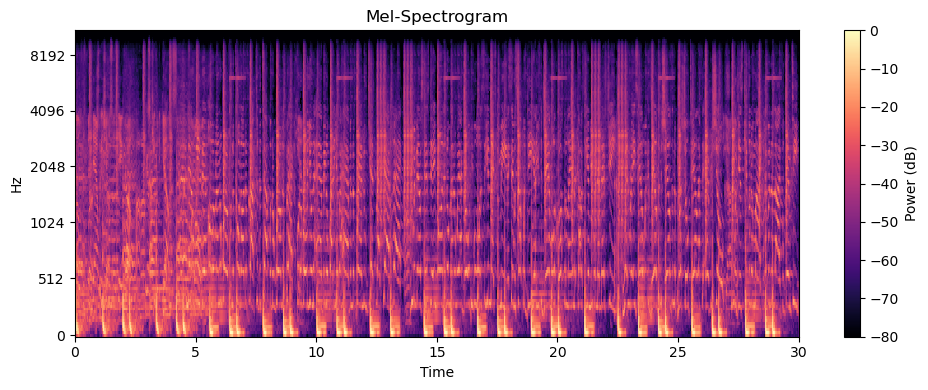

In [6]:
mel_spec = librosa.feature.melspectrogram(
    y=y,
    sr=sr,
    n_fft=2048,
    hop_length=512,
    n_mels=128
)

plt.figure(figsize=(10, 4))
librosa.display.specshow(
    librosa.power_to_db(mel_spec, ref=np.max),
    sr=sr,
    hop_length=512,
    x_axis="time",
    y_axis="mel"
)
plt.colorbar(label="Power (dB)")
plt.title("Mel-Spectrogram")
plt.tight_layout()
plt.show()


Um die hohe Dimensionalität des Mel-Spektogramms zu reduzieren und eine kompakte Merkmalrepräsentation für maschinelles Lernen zu erhalten, werden im nächsten Schritt die Mel-Frequency Cepstral Coefficients (MFCC) berechnet.

MFCCs fassen die Form des Spektrums in jedem Zeitfenster zusammen und beschreiben damit die Klangfarbe der Musikdatei. Die Berechnung übernimmt wieder <code>librosa</code>. Erfolgt jedoch vereinfacht in folgenden Schritten: 
<ul>
  <li>Berechnung des Mel-Spektogramms (wie oben)</li>
  <li>Logarithmierung</li>
  <li>Diskrete Kosinustransformation zur Dekorrelation der Merkmale</li>
</ul>


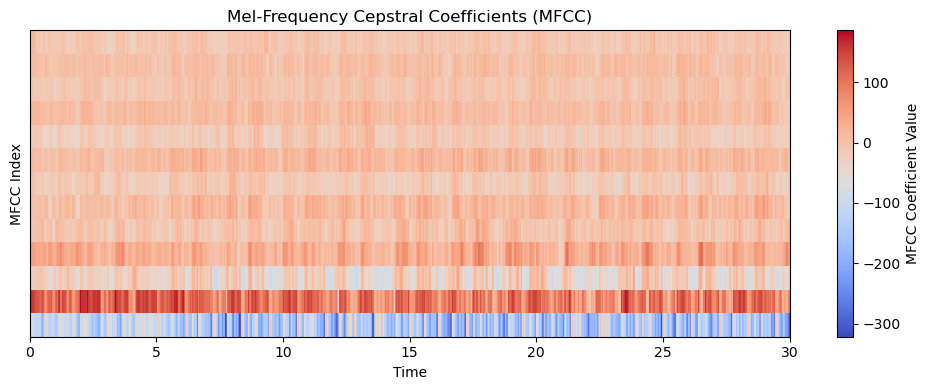

In [7]:
mfcc = librosa.feature.mfcc(
    y=y,
    sr=sr,
    n_mfcc=13,
    n_fft=2048,
    hop_length=512
)

plt.figure(figsize=(10, 4))
librosa.display.specshow(
    mfcc,
    sr=sr,
    hop_length=512,
    x_axis="time"
)
plt.colorbar(label="MFCC Coefficient Value")
plt.title("Mel-Frequency Cepstral Coefficients (MFCC)")
plt.ylabel("MFCC Index")
plt.tight_layout()
plt.show()


Die MFCC Darstellung respektive die errechneten MFCC Matrizen werden als Eingabemerkmal für das Trainieren der Klassifikationsmodelle verwendet.

Ein Track à 30 Sekunden wird in 10 Segmente unterteilt. Somit entstehen pro Track 10 Samples à 3 Sekunden.
Der aufbereitete Datensatz besteht aus zirka 10000 Samples.

Es werden 13 MFCC-Koeffizienten pro Zeitfenster verwendet. Ein Zeitfenster entspricht zirka 93 Millisekunden. 
<code>n_fft = 2048 Samples --> 2048/22050=93</code>

Die Schrittweite zwischen den Fenstern (Hop Length) entspricht <code>512/22050 = 23 ms</code>
Daraus entsteht eine Überlappung der Fenster und somit eine glatte zeitliche Auflösung der einzelnen Samples.

Die MFCC Merkmale der GTZAN Audiodateien wurden vorab in einem separaten <code>.json</code> Datei gespeichert.

<H3>MFCC Merkmale aus .json laden</H3>

In [8]:
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)

    #konvertiere list in numpy array
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

<H1>2. CNN Modell</H1>

Das CNN soll lokale zeitliche und frequenzielle Muster in den MFCC-Matrizen lernen für eine automatische Genre Klassifikation.

<H2>Train/ Test Split und Validierungsdaten</H2>

In [9]:
def prepare_datasets(test_size, validation_size):
    #daten laden
    X, y = load_data(DATA_PATH)
    
    #train/test split
    X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=test_size, random_state=42)

    #train/ validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=42)

    # 3d array --> (130, 13, channel [1])
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [10]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

<H2>Netzwerk Architektur</H2>

In [11]:
def build_model(input_shape):

    #CNN Model
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=input_shape))

    #Convolutional Layer 1
    model.add(keras.layers.Conv2D(32, (3,3),activation ="relu", padding="same"))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))
    model.add(keras.layers.BatchNormalization())

    #Convolutional Layer 2
    model.add(keras.layers.Conv2D(32, (3,3),activation ="relu", padding="same"))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))
    model.add(keras.layers.BatchNormalization())

    #Convolutional Layer 2
    model.add(keras.layers.Conv2D(32, (2,2),activation ="relu", padding="same"))
    model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding="same"))
    model.add(keras.layers.BatchNormalization())

    #flatten
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.25))

    #Output Layer
    model.add(keras.layers.Dense(10, activation="softmax"))

    return model

In [12]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

2026-01-15 21:17:29.574508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13294 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:65:00.0, compute capability: 8.6


<H2>Compile Netzwerk</H2>

In [13]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 130, 13, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 65, 7, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 65, 7, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 65, 7, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 33, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 33, 4, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 33, 4, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1088)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        69,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,426 (329.79 KB)

 Trainable params: 84,234 (329.04 KB)

 Non-trainable params: 192 (768.00 B)

<H2>Train Netzwerk</H2>

In [14]:
early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30, callbacks=[early])

Epoch 1/30


I0000 00:00:1768511852.163598  123268 service.cc:146] XLA service 0x7fca3c004040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768511852.163661  123268 service.cc:154]   StreamExecutor device (0): NVIDIA A16, Compute Capability 8.6
2026-01-15 21:17:32.258850: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-15 21:17:32.499635: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2026-01-15 21:17:32.708056: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 48/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1161 - loss: 2.8156

I0000 00:00:1768511856.353924  123268 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.1944 - loss: 2.3828 - val_accuracy: 0.3956 - val_loss: 1.7070
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4178 - loss: 1.6464 - val_accuracy: 0.4743 - val_loss: 1.4636
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4527 - loss: 1.5132 - val_accuracy: 0.5143 - val_loss: 1.3479
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5006 - loss: 1.3821 - val_accuracy: 0.5557 - val_loss: 1.2564
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5373 - loss: 1.2954 - val_accuracy: 0.5664 - val_loss: 1.2266
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5589 - loss: 1.2410 - val_accuracy: 0.5851 - val_loss: 1.1725
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5829 - loss: 1.1741 - val_accuracy: 0.6044 - val_loss: 1.1026
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6135 - loss: 1.1088 - val_accuracy: 0.6271 - va

In [16]:
#es folgen ein paar Hilfsfunktionen für die spätere Visualisierung

def plot_history(history):
    
    plt.figure(figsize=(14, 6))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Loss über Epochen')
    plt.xlabel('Epochen (Iterationen über Daten)')
    plt.ylabel('Loss (Sparse Categorical Crossentropy)')
    plt.legend()
    plt.grid(True)
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Accuracy über Epochen')
    plt.xlabel('Epochen (Iterationen über Daten)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


In [17]:
def load_mapping(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
    return data["mapping"]

class_names = load_mapping(DATA_PATH)

In [18]:
def evaluate_model(
    model,
    X,
    y,
    class_names,
    model_name="Model",
    normalize=True,
    show_report=True
):
    """
    Evaluate a classification model with confusion matrices and optional report.

    Parameters
    ----------
    model : tf.keras.Model
        Trained Keras model.
    X : np.ndarray
        Input data (e.g. X_test).
    y : np.ndarray
        True labels.
    class_names : list[str]
        List of class/genre names in correct label order.
    model_name : str
        Name of the model (used in plot titles).
    normalize : bool
        Whether to show a normalized confusion matrix.
    show_report : bool
        Whether to print classification report.
    """

    # Predictions
    y_prob = model.predict(X, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    # ---------- Confusion Matrix (Counts)
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names
    )
    disp.plot(
        xticks_rotation=90,
        values_format="d",
        cmap=None
    )
    plt.title(f"{model_name} – Confusion Matrix (Counts)")
    plt.tight_layout()
    plt.show()

    # ---------- Confusion Matrix (Normalized per true class)
    if normalize:
        cm_norm = confusion_matrix(y, y_pred, normalize="true")

        plt.figure(figsize=(10, 8))
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm_norm,
            display_labels=class_names
        )
        disp.plot(
            xticks_rotation=90,
            values_format=".2f",
            cmap=None
        )
        plt.title(f"{model_name} – Confusion Matrix (Normalized)")
        plt.tight_layout()
        plt.show()

    # ---------- Classification report
    if show_report:
        print(f"\nClassification Report – {model_name}")
        print(
            classification_report(
                y,
                y_pred,
                target_names=class_names,
                digits=3
            )
        )

    return y_pred


<H1>3. erweitertes CNN Modell</H1>

Das zweite Modell erweitert die MFCC Eingaben mit der ersten und zweiten zeitichen Ableitung <em>Delta</em> und <em>Delta-Delta</em>. Die ursprüngliche MFCCs beschreiben die momentane Struktur. Während die Delta-Koeffizienten die Änderung der Struktur über die Zeit erfasst, vergleichbar mit einer Geschwindigkeit. Die Delta-Delta Koeffizienten entsprechen der Beschleunigung dieser Änderung. 

Die drei Merkmale werden als separate Kanäle kombiniert und bilden eine dreidimensionale Eingabestruktur, analog zu den Farbkanälen eines RGB Bildes. Das Modell soll dabei statische und dynamische Eigenschaften der Musikdateien berücksichtigen.

In [19]:
# X_train hat (N,130,13,1) -> kanal entfernen
X_train_3d = X_train[..., 0]  # (N,130,13)
X_val_3d   = X_validation[..., 0]
X_test_3d  = X_test[..., 0]

In [20]:
print(X_train_3d.shape)
print(X_val_3d.shape)
print(X_test_3d.shape)

(5993, 130, 13)
(1499, 130, 13)
(2498, 130, 13)


In [21]:
#Funktion zum hinzufügen des Delta und Delta-Deltas, wiederum über die Libraray librosa

def add_deltas(X):
    """
    Add delta and delta-delta features to MFCCs.

    Parameters
    ----------
    X : np.ndarray
        Shape (N, T, 13) – MFCC features without channel dimension.

    Returns
    -------
    np.ndarray
        Shape (N, T, 13, 3) – MFCC, delta, delta-delta stacked as channels.
    """
    X_out = []

    for x in X:
        # x: (T, 13)
        mfcc = x.T  # (13, T)

        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)

        # Stack channels -> (13, T, 3)
        stacked = np.stack([mfcc, delta, delta2], axis=-1)

        # Back to (T, 13, 3)
        X_out.append(stacked.transpose(1, 0, 2))

    return np.array(X_out, dtype=np.float32)


In [22]:
#die neuen trainings, test und validierungsdaten haben nun das gewünschte Format

X_train_3d = add_deltas(X_train_3d)
X_val_3d = add_deltas(X_val_3d)
X_test_3d = add_deltas(X_test_3d)

print(X_train_3d.shape, X_val_3d.shape, X_test_3d.shape)  # (..,130,13,3)

(5993, 130, 13, 3) (1499, 130, 13, 3) (2498, 130, 13, 3)


Wir können uns die drei Kanäle auch visuell darstellen.

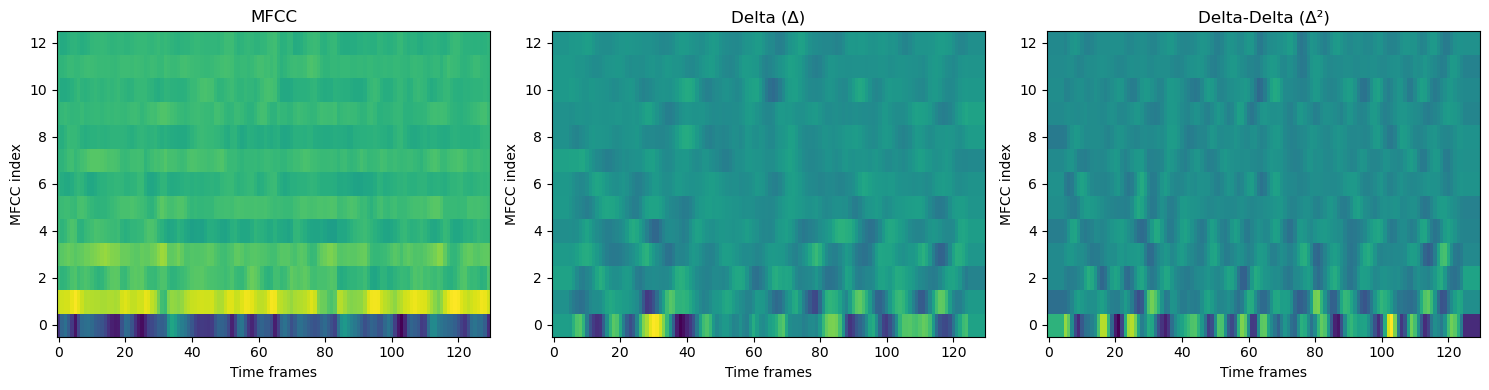

In [23]:
idx = 0  # oder irgendein Index
X_sample = X_test_3d[idx]   # shape: (130, 13, 3)
y_sample = y_test[idx]

mfcc   = X_sample[:, :, 0]
delta  = X_sample[:, :, 1]
delta2 = X_sample[:, :, 2]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].imshow(mfcc.T, aspect="auto", origin="lower")
axs[0].set_title("MFCC")

axs[1].imshow(delta.T, aspect="auto", origin="lower")
axs[1].set_title("Delta (Δ)")

axs[2].imshow(delta2.T, aspect="auto", origin="lower")
axs[2].set_title("Delta-Delta (Δ²)")

for ax in axs:
    ax.set_xlabel("Time frames")
    ax.set_ylabel("MFCC index")

plt.tight_layout()
plt.show()

Für das zweite Modell wird die gleiche Modellarchitektur verwendet, um Erbenisse besser vergleichen zu können. 
Wiederum wird das Modell:
<ul>
    <li>kompiliert</li>
    <li>trainiert</li>
</ul>


In [24]:
input_shape_3d = (X_train_3d.shape[1], X_train_3d.shape[2], X_train_3d.shape[3]) 
model_3d = build_model(input_shape_3d)

#compile 3d Modell
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_3d.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_3d.summary()

#fit 3d Modell
history_3d = model_3d.fit(X_train_3d, y_train, validation_data=(X_val_3d, y_validation), batch_size=32, epochs=30, callbacks=[early])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 130, 13, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 65, 7, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 65, 7, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 65, 7, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 33, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 33, 4, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 33, 4, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 17, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1088)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        69,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,002 (332.04 KB)

 Trainable params: 84,810 (331.29 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.2569 - loss: 2.2124 - val_accuracy: 0.3863 - val_loss: 1.6979
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4119 - loss: 1.6298 - val_accuracy: 0.4850 - val_loss: 1.4146
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4728 - loss: 1.4656 - val_accuracy: 0.5264 - val_loss: 1.2935
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5250 - loss: 1.3410 - val_accuracy: 0.5730 - val_loss: 1.1950
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5554 - loss: 1.2629 - val_accuracy: 0.5677 - val_loss: 1.1825
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5630 - loss: 1.1949 - val_accuracy: 0.5991 - val_loss: 1.1114
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.1383 - val_accuracy: 0.6137 - val_loss: 1.0620
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6228 - loss: 1.0632 - val_accuracy: 

<H1>4. Interpretation der Ergebnisse</H1>

Es folgen der Loss und Accuracy der Modelle über die Epochen hinweg.
Sowie eine ConfusionMatrix auf bisher ungesehen Testdaten.

<H2>erstes CNN Modell</H2>

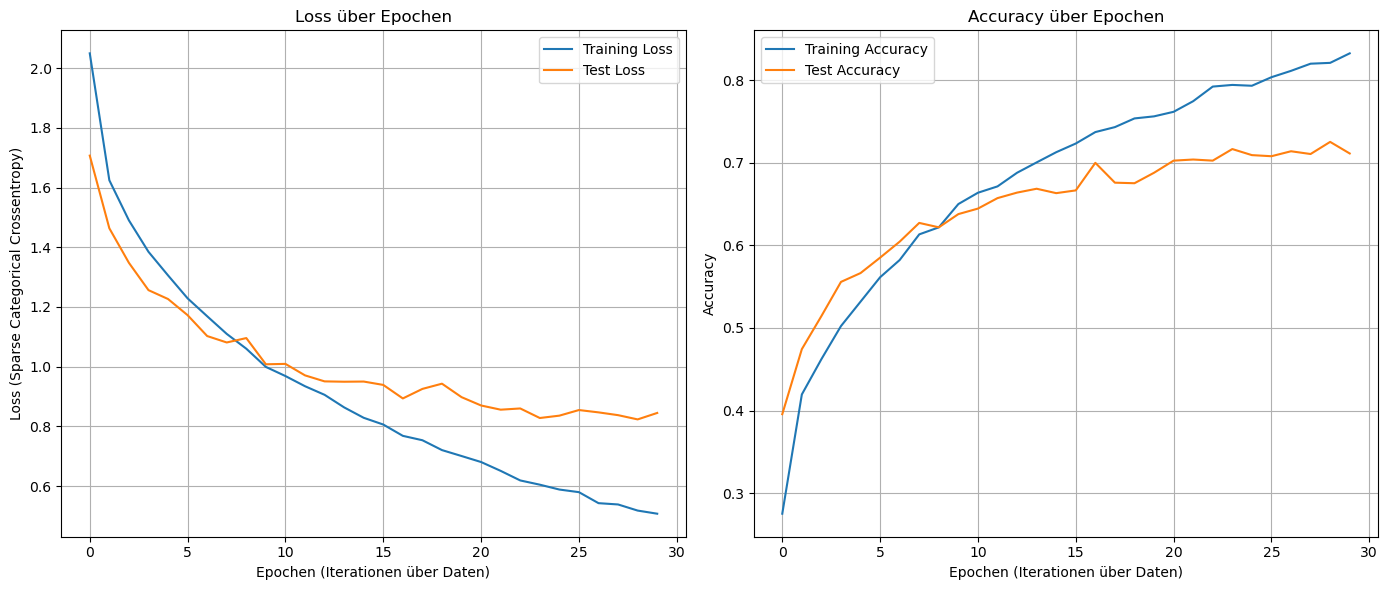

In [25]:
plot_history(history)

In [26]:
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Validation Loss: 0.7862
Validation Accuracy: 0.7290


<Figure size 1000x800 with 0 Axes>

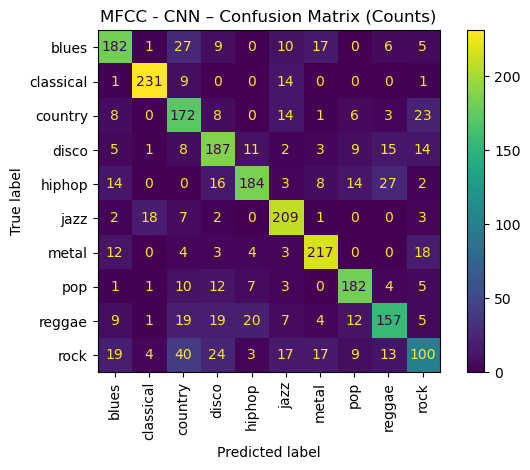

<Figure size 1000x800 with 0 Axes>

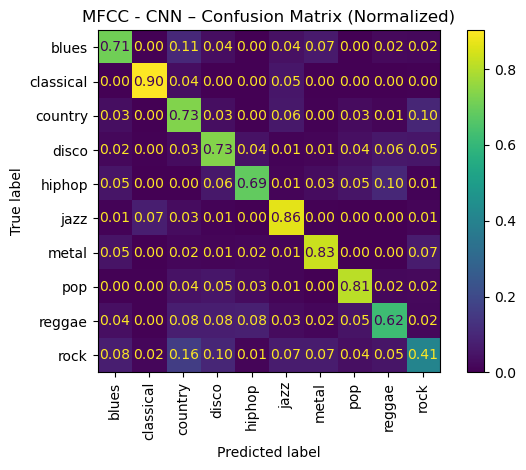


Classification Report – MFCC - CNN
              precision    recall  f1-score   support

       blues      0.719     0.708     0.714       257
   classical      0.899     0.902     0.901       256
     country      0.581     0.732     0.648       235
       disco      0.668     0.733     0.699       255
      hiphop      0.803     0.687     0.740       268
        jazz      0.741     0.864     0.798       242
       metal      0.810     0.831     0.820       261
         pop      0.784     0.809     0.796       225
      reggae      0.698     0.621     0.657       253
        rock      0.568     0.407     0.474       246

    accuracy                          0.729      2498
   macro avg      0.727     0.729     0.725      2498
weighted avg      0.729     0.729     0.725      2498



array([4, 5, 9, ..., 9, 7, 4])

In [27]:
evaluate_model(
    model=model,
    X=X_test,
    y=y_test,
    class_names=class_names,
    model_name="MFCC - CNN"
)

Wir sehen, dass der Trainingsloss über die Epochen hinweg sinkt. Das Modell ist in der Lage die Trainigsdaten zunehmend besser zu erklären. Der Validierungsloss fällt ebenfalls, stabilisiert sich aber zunehmends ab Epoche 20. Dies deutet auf den Beginn von Overfitting hin. Das Modell lernt weiterhin spezfische Muster aus den Trainingsdaten, ohne die Generalisierung weiterhin zu verbessern. 

Während das Genre "classical" ziemlich gut predicted werden kann hat das Modell mühe bei der Klassifikation von "rock". Für dieses Genre wird öfters "country" predicted. Ich würde argumentieren, dass die Unterscheidung dieser beiden Genres auch für menschliche Hörer nicht ganz trivial ist.

<H2>zweites CNN Modell (mit Deltas)</H2>

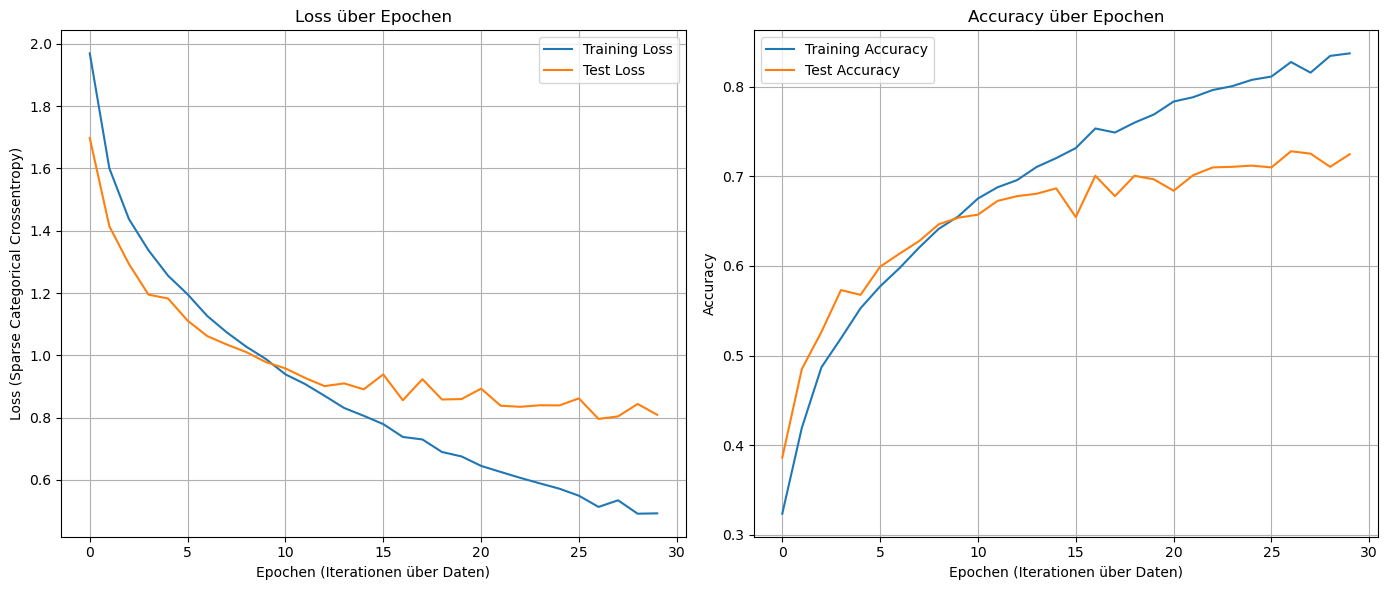

In [28]:
plot_history(history_3d)

In [29]:
val_loss_3d, val_acc_3d = model_3d.evaluate(X_test_3d, y_test, verbose=0)
print(f"Validation Loss: {val_loss_3d:.4f}")
print(f"Validation Accuracy: {val_acc_3d:.4f}")

Validation Loss: 0.7743
Validation Accuracy: 0.7266


<Figure size 1000x800 with 0 Axes>

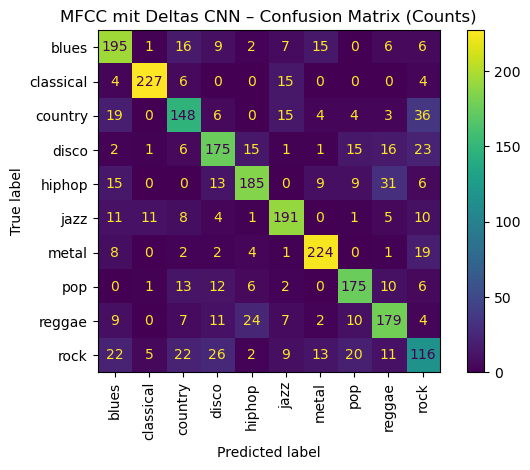

<Figure size 1000x800 with 0 Axes>

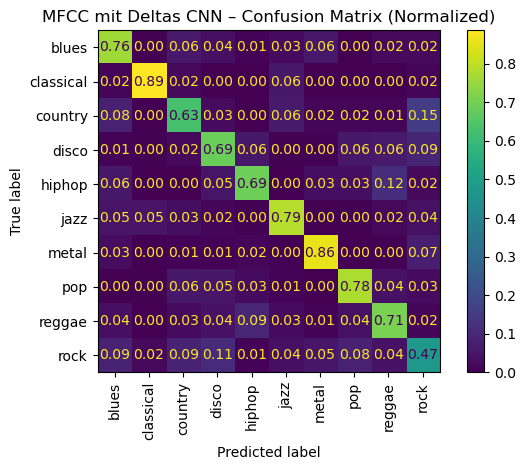


Classification Report – MFCC mit Deltas CNN
              precision    recall  f1-score   support

       blues      0.684     0.759     0.720       257
   classical      0.923     0.887     0.904       256
     country      0.649     0.630     0.639       235
       disco      0.678     0.686     0.682       255
      hiphop      0.774     0.690     0.730       268
        jazz      0.770     0.789     0.780       242
       metal      0.836     0.858     0.847       261
         pop      0.748     0.778     0.763       225
      reggae      0.683     0.708     0.695       253
        rock      0.504     0.472     0.487       246

    accuracy                          0.727      2498
   macro avg      0.725     0.726     0.725      2498
weighted avg      0.726     0.727     0.726      2498



array([4, 5, 6, ..., 9, 7, 4])

In [30]:
evaluate_model(
    model=model_3d,
    X=X_test_3d,
    y=y_test,
    class_names=class_names,
    model_name="MFCC mit Deltas CNN"
)

Es ist festzustellen, dass die drei Kanäle keine deutliche Steigerung auf die Klassifikation hat im Vergleich zum ersten Modell. Dieses Modell hat ebenfalls Schwierigkeiten bei der Klassifikation des Genres "rock".

Untenstehen sieht man jedoch, dass das zweite Modell durchaus die Delta und Delta-Delta Inputs im gelernten Modell berücksichtigt. 

In [31]:
conv1 = model_3d.layers[0]   
W, b = conv1.get_weights()

print(W.shape)



(3, 3, 3, 32)


In [32]:
channel_energy = np.mean(np.abs(W), axis=(0,1,3))
print("MFCC:", channel_energy[0])
print("Delta:", channel_energy[1])
print("Delta-Delta:", channel_energy[2])


MFCC: 0.06819144
Delta: 0.069051884
Delta-Delta: 0.07219729


Im Vergleich mit einem zuvor gelerntem FFNN (siehe Ordner FFNN) erzielen die CNN Modelle eine höhere Genauigkeit auf bisher ungesehenen Daten. Die CNNs scheinen die zeitlich-frequenzielle Struktur der MFCC Matrizen ausnutzen zu können und sind dabei parametereffizienter als ein FFNN (fully-connected). Der Vergleich basiert auf identischen Datensplits und Inputdaten.